## 12-13. 프로젝트: 뉴스기사 요약해보기
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import nltk
nltk.download('stopwords')

from importlib.metadata import version
import tensorflow
import summa
import pandas as pd
import numpy as np
import os,sys,copy,time
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')
print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3
3.6.5
2.6.0
1.2.0


### Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

sunnysai12345/News_Summary: https://github.com/sunnysai12345/News_Summary
아래의 코드로 데이터를 다운로드할 수 있어요.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
27012,DonÃ¢ÂÂt end marriages over small issues: Go...,Goa Governor Mridula Sinha on Saturday adminis...
12774,Not ashamed that I worked as a welder: Pak's M...,"Pakistan pacer Mohammad Abbas, who won the Man..."
39608,"Antarctica also witnesses earthquakes, confirm...",Long thought to be silent because of ice cover...
94994,Pepsi faces flak for new ad featuring Kendall ...,Pepsi has been criticised for 'trivialising' p...
59927,Govt announces reward for photos of illegally ...,Transport Minister Nitin Gadkari has asked cit...
23516,CBI court sentences 4 Vyapam scam accused to 4...,CBI court on Tuesday sentenced each of the fou...
28691,"Child rape inexcusable, no mercy can be shown ...",While upholding the life sentence awarded to a...
65060,Jharkhand girl who starved to death had Aadhaa...,The family of the 11-year-old girl in Jharkhan...
28779,"PNB sets up loan recovery cells in all its 6,9...",State-run Punjab National Bank (PNB) has repor...
25874,Elon Musk's submarine was a PR stunt: Thai cav...,One of the divers who helped rescue 12 kids st...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [4]:
print(data.shape,data.columns)

#랜덤한 15개 샘플 출력
data.sample(15)

(98401, 2) Index(['headlines', 'text'], dtype='object')


,headlines,text
96958,Up to 137% tax for not declaring black money t...,The I-T department on Friday urged black money...
30002,"If talent was appreciated, I'd have been a sta...",Actor Annu Kapoor has said if content and tale...
96841,F1 driver asked to diet to compensate for over...,Force India's Mexican driver Sergio PÃÂ©rez h...
34255,BJP MP's son arrested for consuming liquor in ...,The 18-year-old son of a BJP MP has been arres...
90695,Ambulance service for cows launched in Uttar P...,The Uttar Pradesh government recently launched...
2318,9 kids in Raj fall sick after being given expi...,As many as nine children fell ill after they w...
4732,Gold jewellery worth Ã¢ÂÂ¹31L found in Air In...,Gold jewellery worth over Ã¢ÂÂ¹31 lakh was se...
40598,India ranks 9th globally in cryptojacking acti...,India is the ninth most affected country in th...
51119,Team of chefs to ensure PM Modi gets Indian fo...,A team of 32 chefs and managers from the Taj G...
22424,"Trump hosts Indra Nooyi, Mastercard's Ajay Ban...",US President Donald Trump on Tuesday hosted co...


### Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

중복 샘플과 NULL 값이 존재하는 샘플 제거


In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# text 중복값제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트 정규화와 불용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터 전처리 함수생성: 정규화,불용어,데이터 정제처리등

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전체 text 데이터에 대한 전처리

In [11]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

전체 headlines 데이터에 대한 전처리: headlines의 길이가 짧아보이지 않아서, 불용어처리 True

In [12]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, True))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines 

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)


In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136183407889386


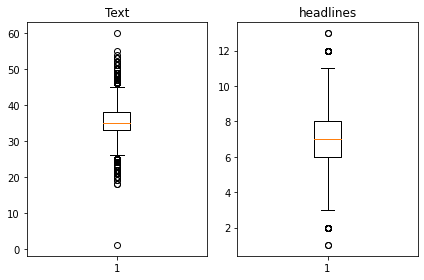

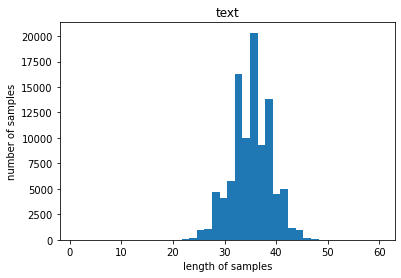

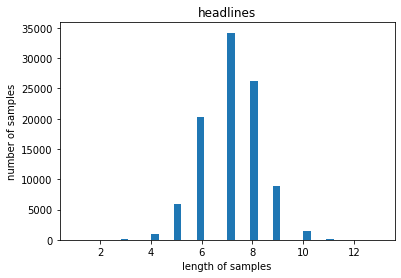

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
text_max_len = 40
headlines_max_len = 8


In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.8925782838552258


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 81914


시작 토큰과 종료 토큰 추가하기

In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
7,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
9,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


#### 훈련 데이터와 테스트 데이터를 분리 : 8:2의 비율

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[38087 21413 36768 ... 38220 40801 33770]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16382


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 65532
훈련 레이블의 개수 : 65532
테스트 데이터의 개수 : 16382
테스트 레이블의 개수 : 16382


#### encoder_input_train  토큰화

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


토큰화시킨 encoder_input_train data의 단어들의 빈도수 파악

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 63227
등장 빈도가 6번 이하인 희귀 단어의 수: 43201
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20026
단어 집합에서 희귀 단어의 비율: 68.32682240182201
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9051952397901983


##### Token화시킨 encoder_input_train data 통계특징

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 희귀단어들은 단어 집합에서 무려 68.3% 를 차지, 

실제로 encoder_input_train data에서 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.89 %임,

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거.

이를 제외한 단어 집합의 크기를 19000 여개, 작업효율상 좀 더 적은 값으로 어림잡아 단어 집합의 크기를 10000 으로 제한함

src_vocab = 10000

In [29]:
# Tokenizer 활용해서, 단어 집합 15000개로 재생성
src_vocab =  10000
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)


text 시퀀스를 정수 시퀀스로 변환

In [30]:
# text 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[773, 3201, 1420, 9535, 188, 14, 137, 66, 57, 1927, 520, 8560, 165, 205, 1036, 453, 114, 165, 143, 1218, 2, 65, 155, 276, 5606, 1803, 8561, 1639], [474, 597, 61, 4235, 7635, 76, 171, 472, 3520, 6559, 9309, 342, 6767, 4039, 474, 451, 619, 605, 244, 191, 1548, 417, 4039, 694, 35, 4123, 1, 76, 210, 171, 4123, 474, 171], [599, 2868, 1270, 198, 2625, 1432, 801, 233, 1526, 3521, 1270, 4947, 63, 977, 195, 106, 8, 190, 371, 128, 77, 229, 1270, 1282]]


#### decoder_input_train 토큰화

In [31]:
# headlines 시퀀스를 정수 시퀀스로 변환
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


토큰화시킨 decoder_input_train data의 단어들의 빈도수 파악

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27521
등장 빈도가 5번 이하인 희귀 단어의 수: 18207
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9314
단어 집합에서 희귀 단어의 비율: 66.15675302496275
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.758120026229304


##### Token화시킨 decoder_input_train data 통계특징

등장 빈도가 5회 이하인 희귀단어들은 단어 집합에서 약 66%를 차지,

실제로 decoder_input_train data에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 6.76%

희귀단어 모두 제거시 단어집합수 9000여개인데, 작업효율상 2,500을 단어 집합의 크기로 제한

tar_vocab = 2500

In [33]:
tar_vocab = 2500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)  # decoder_input_train 토큰화
tar_tokenizer.fit_on_texts(decoder_target_train) # decoder_target_train 토큰화

# 텍스트 시퀀스를 정수 시퀀스로 변환: 
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 145, 934, 7, 526], [1, 186, 816, 1341], [1, 355, 2169, 2264, 1035, 356, 1073], [1, 708, 1182, 176, 373, 1912, 57], [1, 27, 158, 1183, 2428]]
target
decoder  [[145, 934, 7, 526, 2], [186, 816, 1341, 2], [355, 2169, 2264, 1035, 356, 1073, 2], [708, 1182, 176, 373, 1912, 57, 2], [27, 158, 1183, 2428, 2]]


전체 데이터에서 빈도수가 낮은 단어가 삭제되면서, 발생될수 있는 empty 샘플 제거

In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 95
삭제할 테스트 데이터의 개수 : 39
훈련 데이터의 개수 : 65437
훈련 레이블의 개수 : 65437
테스트 데이터의 개수 : 16343
테스트 레이블의 개수 : 16343


#### 패딩하기
같은 길이로 맞춰주는 패딩 작업

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')


데이터 전처리 완료

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

#### 인코더 설계
Attention이있는 인코더는 일반 seq2seq와는 다르게, 인코더 LSTM layer의 인자에 return_sequence=True 설정해야함(timestep별 state가 모두 필요하므로) 

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 256#128  # 256  #128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
enc_emb = BatchNormalization()(enc_emb) #my


# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_output1 = BatchNormalization()(encoder_output1) #my

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_output2 = BatchNormalization()(encoder_output2) #my

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
encoder_outputs = BatchNormalization()(encoder_output2) #my

#### 디코더 설계
디코더는 당연히 일반seq2seq와 동일하게 return_sequences= True 설정(이전 timestep output이 다음 timestep의 input이 되므로)

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
dec_emb = BatchNormalization()(dec_emb) #my

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_outputs = BatchNormalization()(decoder_outputs) #my

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

#### seq2seq 기초 모델 생성

In [38]:
#del model

NameError: name 'model' is not defined

In [39]:
# 모델 생성
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 256)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 256)      1024        embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 525312      batch_normalization[0][0]        
______________________________________________________________________________________________

#### 어텐션 메커니즘

TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 결합해서 사용.
(Bahdanau 스타일)

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든time step의 hidden state를어텐션층에전달하고 결과를리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 256)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 256)      1024        embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 525312      batch_normalization[0][0]        
____________________________________________________________________________________________

#### Attention 모델 학습

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
256/256 [==============================] - 28s 76ms/step - loss: 3.7430 - val_loss: 6.9720
Epoch 2/50
256/256 [==============================] - 18s 71ms/step - loss: 2.7675 - val_loss: 3.0886
Epoch 3/50
256/256 [==============================] - 18s 70ms/step - loss: 2.3704 - val_loss: 2.6430
Epoch 4/50
256/256 [==============================] - 18s 70ms/step - loss: 2.1142 - val_loss: 2.5951
Epoch 5/50
256/256 [==============================] - 18s 70ms/step - loss: 1.9247 - val_loss: 2.5734
Epoch 6/50
256/256 [==============================] - 18s 70ms/step - loss: 1.7768 - val_loss: 2.6130
Epoch 7/50
256/256 [==============================] - 18s 70ms/step - loss: 1.6552 - val_loss: 2.6745
Epoch 00007: early stopping


plotting

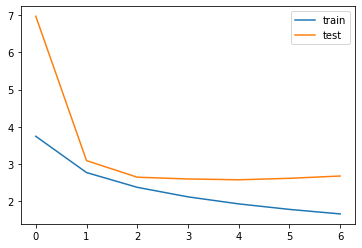

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델:  모델 성능 테스트
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전 미리 준비.

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


테스트용 인코더 설계

In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


Attention 레이어 생성,테스트용 디코더 설계 및 최종 모델 생성

In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 softmax 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


#### 인퍼런스 단계에서 단어 시퀀스를 완성하는 decode_sequence 함수정의

In [46]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [47]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


#### 추상적 요약의 결과를 비교

In [48]:
for i in range(0, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : indian sprinter chand silver medal asian games running seconds awarded crore odisha government award announced state chief minister naveen patnaik notably became first indian sprinter bag medal event asian games since 
실제 요약 : silver running get crore 
예측 요약 :  wins wins wins wins wins wins wins


원문 : japanese conglomerate softbank talks invest million us based dog sitting app according reports comes months startup slammed allegedly losing customers pets care founded gives demand access dog hired users dog walking dog sitting 
실제 요약 : softbank may invest mn dog app 
예측 요약 :  invest invest dog dog dog dog dog


원문 : actor oscar isaac revealed late actress slap times filming scene film star wars last added every time would hit like different spot face died suffering heart attack played princess star wars franchise 
실제 요약 : times star scene oscar 
예측 요약 :  actress late times times times times actress


원문 : gitanjali gems owner mehul choksi letter employees said done anything wrong 

#### 추상적 요약에 대한 의견

예측요약은 대부분 실제 요약내에 있는 단어에 포함되어있고,포함도지 않은 소수는 원문내에 있어, 핵심 단어수준에서는 개략 맞는 것 같으나,예측문장은 대부분 동일 단어들이 반복되고 있어서, 하나의 문장을 이루지 못하고 있슴,

좀더 모델성능향상을 위한 모델구조개선과 하이퍼파라메터등을 개선 적용해서,EPOCH를 충분히 늘려서, 적용하면 좀 더 나아질것 같으나, 
궁극적으로 트랜스포머에대한 기대감이 커짐

### Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [49]:
from summa.summarizer import summarize

In [50]:
import pandas as pd
data_summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

#### 앞의 추상적요약에서 다루었던 news_summary_more.csv 기사 텍스트의 앞쪽 100문장(글자수 36,030자) 대상 추출적 요약실행

In [51]:
text = ",".join(data_summa['text'].tolist()[:100])
print(len(text), text)

36030 Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.,Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match 

In [52]:
print('Summary:')
print(summarize(text, ratio=0.01))

Summary:
He added, "The time has come for the people of Odisha to put a full stop to their activities...The time has come for us to ask for an explanation from this corrupt government.",Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inÃ¢ÂÂ Surat, added that the opposition parties have only one agenda which is "Modi".


In [53]:
print('Summary:')
print(summarize(text, ratio=0.01, split=True))

Summary:
['He added, "The time has come for the people of Odisha to put a full stop to their activities...The time has come for us to ask for an explanation from this corrupt government.",Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inÃ¢Â\x80Â\x8b Surat, added that the opposition parties have only one agenda which is "Modi".']


In [54]:
print('Summary:')
print(summarize(text, words=50))

Summary:
He added, "The time has come for the people of Odisha to put a full stop to their activities...The time has come for us to ask for an explanation from this corrupt government.",Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inÃ¢ÂÂ Surat, added that the opposition parties have only one agenda which is "Modi".


##### 추출적 요약에 관한 의견


추출적요약이 요약비율을 너무 압축시키지 않으면,예를 들어, 10% 정도로 하면, 문장별로는 그럴듯한 것도 있으나, 아닌것도 섞여있슴,

[추상적요약]이 학습이 충분히 된다면, 더 훌륭할것 같은데, 학습이 잘않되는 경우, [추출적요약]이 좀 더 나은 것 같음

## Step 6. 추상적요약 vs. 추출적예약 비교 검토

#### 1. 문법완성도 측면
###### (1) 추상적 요약 : 문법완성도 측면에서 많이 부족함( target data 인 실제요약도 문법적으로 않맞다보니,  predict인 예측요약도 문법은 없고,단어만 나열됨, 이는 원문이  문법이 형성되지 않고 빈도위주의 단어로 구성되어 있는 것도 원인이라고 보임)

###### (2) 추출적요약: 문법완성도 측면에서 양호함(원문이 문법적으로 되어있는 텍스트라서, 거기서 추출되는 형식도 문법적요소가 학습된 것으로 보임)


#### 2. 핵심단어 포함측면
###### (1) 추상적요약 : 실제예측내에 있는 핵심단어는 거의 다 예측요약에 양호하게 포함되어 있슴   
###### (2) 추출적요약:  원문에 있는 핵심단어들을  추출요약에 대체로 잘 포함하고 있슴


#### 3. 종합: 
###### [추상적요약]이 모델구조개선이나, pretrained된 큰규모의 word2vector등을 베이스로 학습이 된다면, 아주 훌륭할것 같은데, 그렇지 않은 환경이거나, 학습이 잘않되는 경우, [추출적요약]이 나을 것 같음


## 회고

본 프로젝트는 뉴스기사데이터를 대상으로 기사내용을 추상적요약법과 추출적요약법의 두가지 방법으로 요약을 해보고,
요약내용의 품질과 요약방법의 성능을 평가해보는 프로젝트입니다.

##### Step 1. 데이터 수집
먼저, 뉴스기사 text 원문과 headline으로 구성된 98,401개 뉴스기사 문장을 로드했습니다

##### Step 2. 데이터 전처리하기 (추상적 요약)
먼저, 먼저 개략적으로 데이터를 살펴보며, 전처리를 위한 분석을 하고서, 중복 샘플을 제거하여, 총98,401개에서 총98,360개로 축소하였습니다.
결측치는 존재하지 않았습니다.

다음은 데이타 정제, 정규화,불용어처리를 위해서, 일괄 처리해줄 함수로 preprocess_sentence(sentence, remove_stopwords=True)를 만들었습니다.
함수안에는 기사 내용에 있는 영어를 제외한 숫자및 특수문자제거, 모든 영문자 소문자로 통일, HTML문제 제거 등 데이터 정제및
데이터 정규화, 불용어처리를 위한 코드를 넣어서, 데이터 전처리를 일괄로 깔끔하게 처리하였습니다.
이때, 문장길이가 상대적으로 짧긴하지만 headlines의 평균문장 길이가 원문 문장길이 평균의 5배차이라 큰 차이가 아니것으로 보고서,
함께 불용어처리를 하였습니다. 

text의 평균길이가 35개, headlines의 평균길이가 7개라서, 단어빈도분포를 따져보고, text_max_len = 40
headlines_max_len = 8 로 결정하였습니다.

이렇게 했을때, 
전체 샘플 중 길이가 40 이하인 샘플의 비율 92.38%, 
전체 샘플 중 길이가 8 이하인 샘플의 비율: 89.25%,    
남은 샘플수는 81914개로, 중복치제거후 기존 총98,360개의 83.2%가 실제 사용샘플수로 남았습니다.  
    
headlies 데이터에는 시작 토큰 'sostoken ' 과 종료 토큰' eostoken'을 추가했습니다.

그리고, 훈련 데이터와 테스트 데이터를  8:2의 비율로 분리하였습니다.
분리하기전에 데이터를 shuffle하여, target data의 분포도 치우치지 않게 하였습니다.    
분리한 결과 훈련 데이터의 개수 65532,훈련 레이블의 개수 65532, 테스트 데이터의 개수 16382, 테스트 레이블의 개수 16382개였습니다.

Tokenizing은 분리된 인코더용 훈련 데이터를 Tokenizer()로 토큰화하고서,희귀단어를 제외시킨후 작업효율을 감안하여,단어집합의 크기(src_vocab)는
10000개로 설정하고서,Tokenizer()를 재생성하였고, text 시퀀스(인코더용train data, 인코더용 test data)를 정수 시퀀스로 변환하였습니다.

마찬가지 요령으로 디코더용(headlines 시퀀스)데이터도 정수 시퀀스로 변환하였습니다. 
이때 단어집합크기(tar_vocab)는 2500개로 설정하였습니다.
    
Padding은 max길이로 문장을 통일시키기위해서, pad_sequences()로 'post'방식으로 패딩을 완료하였습니다
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

이로써 데이터 전처리가 완료되었습니다.


#### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
인코더 설계단계에서 Attention이있는 인코더는 일반 seq2seq와는 다르게, 인코더 LSTM layer의 인자에 return_sequence=True 설정해야하는데,
이는 timestep별 state가 모두 필요하기 때문입니다.
embedding_dim 256,hidden_size 256으로 하였고,인코더 인풋층 다음에 임베딩층, 3개층의 LSTM레이어, 
그리고, 매층뒤에 Bachnormalization층을 설치해서,정규화를 통해 학습이 좀 더 매끄럽게 되도록 했습니다.
그리고, 각 LSTM층에는 dropout인자를 사용하여, 오버피팅을 방지했습니다.

디코더 설계단계에서는 당연히 일반seq2seq와 동일하게 return_sequences= True 설정하였는데,
이는 seq2seq의 특징인 이전 timestep output을  다음 timestep의 input으로 쓰도록 하기위해서입니다.
디코더 인풋층, 임베딩층, LSTM층 1개(dropout사용,return_sequences=True, return_state=True), 
소프트맥스층순으로 하고,매층뒤에 Bachnormalization층을 설치했습니다.

이것으로 Attention 모델을 만들기위한 기반 seq2seq 인코더 디코더는 마련하였습니다.

다음으로 keras의 AdditiveAttention layer를 가져와서, 위의 모델에 어텐션을 조합하여, 어텐션 모델로 만들었습니다.
AdditiveAttention layer는 이미 구현된 레이어로서, attention score를 구하는 방식이 Bahdanau 스타일입니다.
Bahdanau 스타일은 스코어를 구할때, trainable 가중치와 하이퍼볼릭탄젠트함수를 사용하여 계산하는 방식입니다.

어텐션레이어는 인코더의 모든 타임스텝의 states들과 해당 타임스텝시점의 디코더 아웃풋을 인풋으로 받아서,
어텐션 스코어를 산출합니다.

어텐션 레이어를 거친후, concat layer를 거쳐서, 소프트맥스가 있는 Dense 층을 통해, 그 타임스텝시점의 prdeict예측치를
반환하며, 이 예측치는 다음 타임스텝의 인풋으로 들어갑니다,  이 과정은 디코더의 모든 타임스텝동안 반복됩니다.

이러한 과정을 실행하는 어텐션모델이 완성되었습니다.

학습을 하기위해서, 데이터는 train data를 학습데이터로, test data를 valid data로 하고,
batch size 256개, epoch 50회, earlystop callback을 사용하여, 학습을 진행했는데, Epoch 7회에 early stop 되었습니다.
첫번째 Epoch의 val_loss 가 6.97이었는데, 계속 감소하다가, 조기종료된 Epoch 7회 val_loss는 2.6745 였습니다.

history.history['val_loss']로 시각화해보니, val_loss가 우하향 잘하며 loss가 감소해 내려가다가, epoch 7 에서부터,
과대적합이 시작되면서,조기종료되었습니다.

이렇게 학습이 종료되고, 학습된 모델로 어텐션모델 기사요약기로 성능평가를 해봐야하는데,
seq2seq 모델및 어텐션모델은 학습과정과 평가 테스트과정에서, 다르게 실행되는부분이 있는데,
무엇인가 하면,평가 테스트과정에서는, inference 부분(predict부분)에서, 디코더 LSTM 의 매 time step마다,
이전 timestep의 예측치를 받아서, 당 시점 timestep의 인풋으로 넣어주는 반복적인 과정을 별도의 코드로 처리해주어야 하기 때문입니다.
이것을 처리하는 함수는 decode_sequence 함수로 정의하여 사용하였습니다.

#### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

별도의 test data가 마련하지 않아서,valid data로 사용하였지만, 약식 성능테스트이기 때문에,
encoder_input_test data로 기사요약기 성능을 테스트해보았습니다.

첫 기사부터 50개의 기사를 요약시켜보았습니다.

예측요약은 대부분 실제 요약내에 있는 단어에 포함되어있고,포함되지 않은 소수의 기사도 단어가 원문내에 있어, 
핵심 단어수준에서는 잘맞는 것 같으나,예측문장은 대부분 동일 단어들이 반복되고 있어서, 하나의 문장을 이루지 못하고 있어서,
문법적으로는 품질이 많이 떨어졌습니다, 
그런데, 그 원인으로, 원문장 자체가 불용어에 포함되어 삭제된 것이 많아서, 원문도 문법적으로 어색한 상태라서,
심층연구가 아닌 경우, 작은 Epoch등으로 인해, 문법을 익힐 기회가 적어서, 문법학습 부진에도 영향을 미치지 않았나
생각해 봅니다.

좀더 모델성능향상을 위한 모델구조개선과 하이퍼파라메터등을 개선 적용해서,EPOCH를 충분히 늘려서, 적용하면 좀 더 나아질것 같으나, 
궁극적으로 트랜스포머에대한 기대감이 커지고 있습니다.

#### Step 5. Summa을 이용해서 추출적 요약해보기
앞의 추상적요약에서 다루었던 news_summary_more.csv 기사 텍스트의 앞쪽 100문장(글자수 36,030자) 대상 추출적 요약실행해 보았습니다.
전체 기사를 list화 한후 전체를 str 통문장으로 만든후 summa의 summarize로 요약해보았습니다. 

추출적요약을 요약비율을 여러가지로 변경해가면 살펴보았는데, 요약비율을 너무 압축시키지 않는다면,
예를 들어, 10% 정도 이상으로 하면, 문장별로는 그럴듯한 것이 제법 있었고, 문법적으로도 괜찮은 부분이 더 많은 것 같았습니다.


#### Step 6. 추상적요약 vs. 추출적예약 비교 검토
1. 문법완성도 측면
(1) 추상적 요약 : 문법완성도 측면에서 많이 부족함( target data 인 실제요약도 문법적으로 않맞다보니, predict인 예측요약도 문법은 없고,단어만 나열됨, 이는 원문이 문법이 형성되지 않고 빈도위주의 단어로 구성되어 있는 것도 원인이라고 보임)¶
(2) 추출적요약: 문법완성도 측면에서 양호함(원문이 문법적으로 되어있는 텍스트라서, 거기서 추출되는 형식도 문법적요소가 학습된 것으로 보임)
2. 핵심단어 포함측면
(1) 추상적요약 : 실제예측내에 있는 핵심단어는 거의 다 예측요약에 양호하게 포함되어 있슴
(2) 추출적요약: 원문에 있는 핵심단어들을 추출요약에 대체로 잘 포함하고 있슴
3. 종합:
[추상적요약]이 모델구조개선이나, pretrained된 큰규모의 word2vector등을 베이스로 학습이 된다면, 아주 훌륭할것 같은데, 그렇지 않은 환경이거나, 학습이 잘않되는 경우, [추출적요약]이 나을 것 같음
회고

Decoder의 해당 timestep에서, Encoder의 모든 timestep의 결과를 참조하여, 무엇이 정답을 예측하는데,
더 영향을 미치는지 집중(Attention)하게 하는, Attention 아이디어는 seq2seq 모델을 크게 발전시킬수 있는 획기적인 아이디어인 것
이 맞는 것 같습니다.

그 획기적인 발전과정의 초입부분의 프로젝트를 수행하면서, 좀 더 깊은 어텐션에의 이해및 궁극적으로 트랜스포머모델등
앞으로의 발전과정을 좀더 깊이 공부해 볼수 있는 계기와 기대감을 갖게 되었던 것 같습니다.
감사합니다.

